**Residual Mapping 이용한 ResNet**

Deep Neural Network는 더 정확한 결과를 낼 수 있는 방법이지만, vanishing/exploding gradient problem과 같은 문제로 인해 train하기 어려워 실제로 사용하기 어려웠다. ResNet은 이러한 문제를 Residual Mapping을 통해 해결하려고 하였다.

기존의 model들은 x를 input으로 넣었을 때, weight와 activation function을 거친 후 output으로 H(x)를 갖는 구조로 되어있다.

반면에, Residual Mapping은 기존의 output H(x)에 input으로 들어온 x를 빼주는 형태인 output을 갖게 만든다. output F(x) = H(x) - x가 되고, 이를 기존의 구조에 근사하여 H(x)=F(x)+x의 output을 갖는 구조가 된다. 즉, 앞 layer의 output을 현재 layer의 output에 더하는 구조이다. 이 구조를 사용하면 기존의 model들 보다 더 optimize하기 쉽다고 한다.

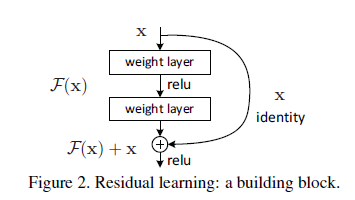


H(x)=F(x)+x를 이용하는 방식을 Shortcut Connection이라고 한다. Shortcut Connection을 이용해서 identity mapping을 하고, 이 output을 기존의 output에 추가한다. Shortcut Connection은 기존에 있는 값을 활용하기 때문에, 새로운 parameter나 연산을 필요로 하지 않는 장점이 있다.



아래 그림은 34 Layer의 ResNet 구조를 VGG-19 모델과 Residual mapping이 없는 Plain 34 Layer network와 비교한 그림이다.

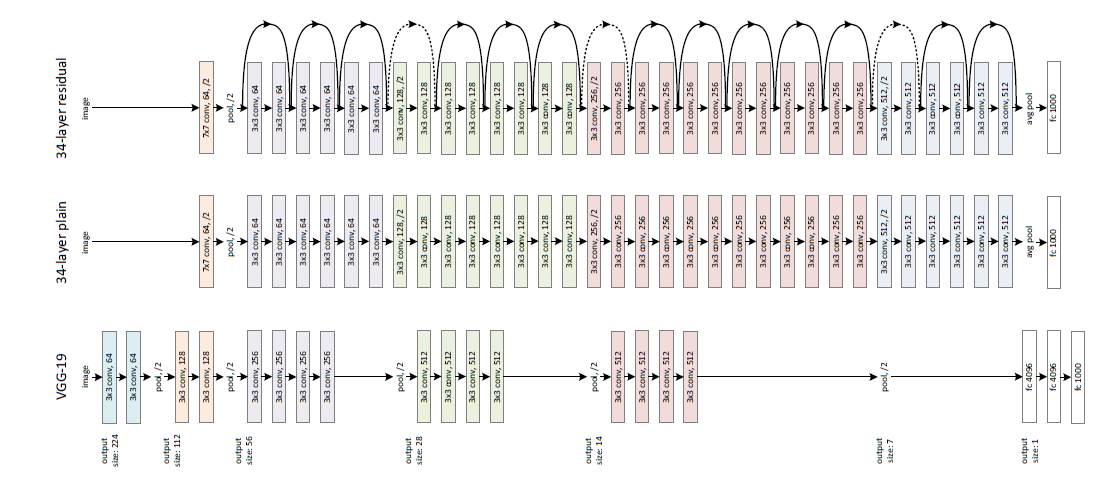

논문에서는 Imagenet의 dataset을 활용하여 224x224로 무작위로 crop하였고, 각각의 convolution 이후에 Batch normalization을 적용하였다. 

**Plain Networks**

18 layer와 34 layer의 Plain Network를 구현하였고, 18 layer보다 34 layer에서 error가 더 크게 나왔다.

**Residual Networks**

Plain과 마찬가지로 18 layer와 34 layer의 ResNet을 구현하였다. 기본적인 구조는 Plain Network와 동일하며, 3x3 필터의 shortcut connection과 Identity mapping, zero padding을 사용하였다. ResNet을 사용한 결과 Plain network에 비해 training error가 감소하였다.

더 Deep한 network를 위해 기존의 Building Block과는 다른 Bottleneck이라는 구조를 사용하였다. 기존의 basic block과는 다르게 1x1, 3x3, 1x1 convolutional Layer로 이루어진 ResNet이다. 왼쪽이 basic block을 사용한 ResNet이고, 오른족이 bottleneck을 사용한 ResNet이다.

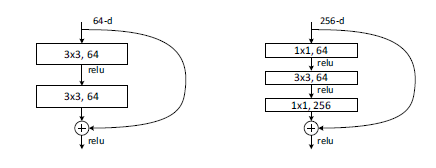


전체 구조는 그림과 같다. 첫 번째 convolutional layer를 제외하고는 각 Layer별로 Block으로 구성되어 있다.

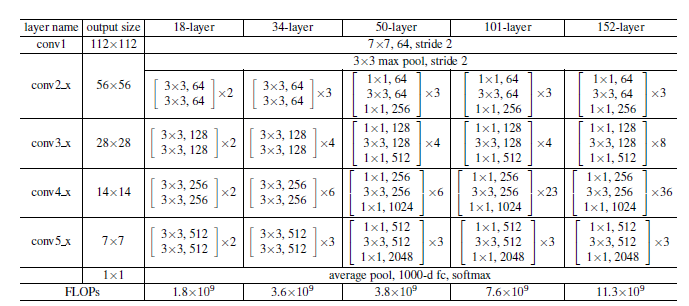

ResNet은 input은 3x224x224 이미지를 사용하였다.

첫번째 Layer는 output channel=64, kernel size=7x7, stride=2, padding=3인 Convolutional Layer이다. 3x224x224 -> 64x112x112

두번째 Layer부터는 Deep한 정도에 따라 BasicBlock과 Bottleneck으로 나누어진다. 논문에서는 ResNet 18과 34에서는 BasicBlock을 사용했고, ResNet 50 이상에서는 Bottleneck을 사용하였다. 

두번째 Layer는 Max pooling Layer 이후에, 3x3 conv, 3x3 conv인 BasicBlock이나 1x1 conv, 3x3 conv, 1x1 conv인 BottleNeck를 사용한 Residual Block을 지난다. Residual Block은 block 수만큼 반복한다. ResNet18은 BasicBlock을 사용하여 2번 반복, ResNet34는 3번 반복한다. ResNet50, 101, 152는 BottleNeck을 사용하여 각각 3번씩 반복한다. 마지막에는 shortcut을 통해 input을 더해줌으로 써 ResNet의 모델 구성을 완성한다.
이 Layer를 지나면 64x112x112 -> 64x56x56이 된다.

세번째 Layer도 Residual Block을 사용한 Layer로 ResNet18은 BasicBlock을 사용하여 2번 반복, ResNet34는 4번 반복한다. ResNet50, 101, 152는 BottleNeck을 사용하여 각각 4번씩 반복한다.마지막에는 shortcut을 통해 input을 더해줌으로 써 ResNet의 모델 구성을 완성한다.
이 Layer를 지나면 64x56x56 -> 128x28x28이 된다.

네번째 Layer도 Residual Block을 사용한 Layer로 ResNet18은 BasicBlock을 사용하여 2번 반복, ResNet34는 6번 반복한다. ResNet50, 101, 152는 BottleNeck을 사용하여 각각 6번, 23번, 36번씩 반복한다.마지막에는 shortcut을 통해 input을 더해줌으로 써 ResNet의 모델 구성을 완성한다.
이 Layer를 지나면 128x28x28 -> 256x14x14가 된다.

다섯번째 Layer도 Residual Block을 사용한 Layer로 ResNet18은 BasicBlock을 사용하여 2번 반복, ResNet34는 3번 반복한다. ResNet50, 101, 152는 BottleNeck을 사용하여 각각 3번씩 반복한다.마지막에는 shortcut을 통해 input을 더해줌으로 써 ResNet의 모델 구성을 완성한다.
이 Layer를 지나면 256x14x14 -> 512x7x7이 된다.

여섯번째 Layer는 Average Pooling 이후에, Fully-Connected Layer를 사용하였고, input은 512 x Expansion이고 output은 Class 수 이다. Expansion은 BasicBlock=1, BottleNeck=4이다.




STL10 dataset과 pytorch로 ResNet 구현해보기 

In [1]:
# 먼저 필요한 Library import 하기

import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils import data

import torchvision.datasets as datasets
import torchvision.transforms as transforms


# 필요한 parameter를 미리 세팅한다.
random_seed=4
learning_rate=0.001
batch_size=32
epochs=101

image_size=224
n_classes=10

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
datapath='/data'

if not os.path.exists(datapath):
  os.mkdir(datapath)

#transforms로 원하는 형태의 dataset으로 변형해준다.
tfData=transforms.Compose([transforms.Resize((256,256)),
                           transforms.RandomCrop(224),  
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
                           ])

# Dataset 다운로드
train_data = datasets.STL10(datapath, split='train', download='True', transform=tfData)
test_data = datasets.STL10(datapath, split='test', download='True', transform=tfData)

print(train_data.data.shape)
print(test_data.data.shape)

train_loader=DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch_size, shuffle=False)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /data/stl10_binary.tar.gz to /data
Files already downloaded and verified
(5000, 3, 96, 96)
(8000, 3, 96, 96)


**ResNet 구현하기**

In [3]:
# Layer 수가 상대적으로 적을 때 사용하는 BasicBlock
class BasicBlock(nn.Module):
  expansion=1

  def __init__(self, n_in, n_out, stride=1):
    super().__init__()

    self.conv1=nn,Conv2d(n_in, n_out, kernel_size=3, padding=1)  # 위 그림에서는 왼쪽 3x3 64(n_out)
    self.norm1=nn.BatchNorm2d(n_out)
    self.act1=nn.ReLU()
    self.conv2=nn.Conv2d(n_out, n_out, kernel_size=3, padding=1)  # 3x3 64(n_out)
    self.norm2=nn.BatchNorm2d(n_out)

    self.shortcut=nn.Sequential()
    

  def forward(self, x):
    x=self.conv1(x)
    x=self.norm1(x)
    x=self.act1(x)
    x=self.conv2(x)
    x=self.norm2(x)
    x+=self.shortcut(x)
    x=F.relu(x)

    return x


In [4]:
# Layer가 많을 때 사용하는 bottleNeck 구현
class BottleNeck(nn.Module):
  expansion=4

  def __init__(self, n_in, n_out, stride=1):
    super().__init__() 

    self.conv1=nn.Conv2d(n_in, n_out, kernel_size=1)  # 위 그림에서는 오른쪽 1x1 64(n_out)  
    self.norm1=nn.BatchNorm2d(n_out)
    self.act1=nn.ReLU()
    self.conv2=nn.Conv2d(n_out, n_out, kernel_size=3, stride=stride, padding=1) # 3x3 64(n_out)
    self.norm2=nn.BatchNorm2d(n_out)
    self.act2=nn.ReLU()
    self.conv3=nn.Conv2d(n_out, n_out*self.expansion, kernel_size=1) # 1x1 256(4*n_out) (논문에서 마지막 1x1은 앞의 4배이므로 expansion=4를 곱했다.)
    self.norm3=nn.BatchNorm2d(n_out*BottleNeck.expansion)
   
    self.shortcut=nn.Sequential()  # input을 전달해주는 부분 H(x)=F(x)+x 에서 x부분
    

  def forward(self, x):
    
    x=self.conv1(x)
    x=self.norm1(x)
    x=self.act1(x)
    
    x=self.conv2(x)
    x=self.norm2(x)
    x=self.act2(x)
    
    x=self.conv3(x)
    x=self.norm3(x)   
    x+=self.shortcut(x)
    x=F.relu(x)

    return x


    

Residual Block을 이용해서 ResNet 만들기

In [5]:
# ResNet 구현하기
class ResNet(nn.Module):
  def __init__(self, blockType, num_blocks, num_classes):  # blockType은 BasicBlock과 Bottleneck중에 선택
                                                           # num_blocks는 논문에 나와있는 Residual Block의 수
    super().__init__()

    self.n_in=64

    # 첫 convolutional Layer
    self.conv1=nn.Conv2d(3,64, kernel_size=7, stride=2, padding=3)
    self.norm1=nn.BatchNorm2d(64)
    self.act1=nn.ReLU()    

    # Residual Blocks
    self.pool1=nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.conv2_x=self.res_layer(blockType, 64, num_blocks[0], stride=1)   # ResNet50의 경우 num_blocks=3
    self.conv3_x=self.res_layer(blockType, 128, num_blocks[1], stride=2)  #                 num_blocks=4 
    self.conv4_x=self.res_layer(blockType, 256, num_blocks[2], stride=2)  #                 num_blocks=6 
    self.conv5_x=self.res_layer(blockType, 512, num_blocks[3], stride=2)  #                 num_blocks=3 

    self.pool2=nn.AdaptiveAvgPool2d((1,1))
    self.fc=nn.Linear(512*blockType.expansion, num_classes)


  def res_layer(self, blockType, n_out, num_blocks, stride):  # ResNet은 같은 Block이 반복됨
    strides=[stride]+[1]*(num_blocks-1)  # 각 Residual Block의 Layer에 사용되는 stride를 정의하기
                                         # 계속 반복되는 Block 중에 첫번째 block은 stride가 2임.

    layers=[]  # 현재 Residual Block 내의 각 layer 만들기
    for stride in strides:                                   
      layers.append( blockType(self.n_in, n_out, stride))  # ResNet50의 경우 64->64->256가 3번
      self.n_in=n_out*blockType.expansion                   #                128->128->512가 4번
                                                            #                256->256->1024가 6번
                                                            #                512->512->2048이 3번
    return nn.Sequential(*layers)


  def forward(self, x):    
    x=self.conv1(x)
    x=self.norm1(x)
    x=self.act1(x)    


    x=self.pool1(x)    
    x=self.conv2_x(x)    
    x=self.conv3_x(x)    
    x=self.conv4_x(x)    
    x=self.conv5_x(x) 
    x=self.pool2(x)

    x=x.view(x.size(0), -1)
    x=self.fc(x)

    return x

각 Layer 수에 따른 ResNet 정의하기

In [6]:
def resnet18():
  return ResNet(BasicBlock, [2,2,2,2],10)  # BasicBlock을 사용하고, conv2_x=2, conv3_x=2, conv4_x=2, conv5_x=2 번 사용

def resnet34():
  return ResNet(BasicBlock, [3,4,6,3],10)  # BasicBlock을 사용하고, conv2_x=3, conv3_x=4, conv4_x=6, conv5_x=3 번 사용
  
def resnet50():
  return ResNet(BottleNeck, [3,4,6,3],10)  # BottleNeck을 사용하고, conv2_x=3, conv3_x=4, conv4_x=6, conv5_x=3 번 사용
 
def resnet101():
  return ResNet(BottleNeck, [3,4,23,3],10)  # BottleNeck을 사용하고, conv2_x=3, conv3_x=4, conv4_x=23, conv5_x=3 번 사용

def resnet152():
  return ResNet(BottleNeck, [3,8,36,3],10)  # BottleNeck을 사용하고, conv2_x=3, conv3_x=8, conv4_x=36, conv5_x=3 번 사용

50 Layer인 ResNet50을 모델로 선택하였다.

In [7]:
model=resnet50().to(DEVICE)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2_x): Sequential(
    (0): BottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BottleNeck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
      (norm1

In [8]:
from torchsummary import summary
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,160
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,928
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,640
      BatchNorm2d-12          [-1, 256, 56, 56]             512
       BottleNeck-13          [-1, 256, 56, 56]               0
           Conv2d-14           [-1, 64,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train

In [9]:
optimizer=optim.Adam(model.parameters(), lr=learning_rate)
criterion=nn.CrossEntropyLoss()

In [10]:
def train(train_loader, model, criterion, optimizer, device):

  running_loss=0
  count=0
  correct=0

  model.train()
  for batch in train_loader:
    X=batch[0]
    y_true=batch[1]

    X=X.to(device)
    y_true=y_true.to(device)   

    # Forward
    y_pred=model(X)
    loss=criterion(y_pred, y_true)
    running_loss+=loss.item()
    batch_correct=torch.argmax(y_pred, dim=1).eq(y_true).sum().item()
    batch_count=len(X)


    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    count+=batch_count
    correct+=batch_correct
  
  epoch_loss=running_loss / len(train_loader.dataset)
  epoch_accuracy=correct/count
  return model, optimizer, epoch_loss, epoch_accuracy   


In [11]:
def evaluation(test_loader, model, criterion, device):

  running_loss=0
  count=0
  correct=0
  
  model.eval()
  for batch in test_loader:
    X=batch[0]
    y_true=batch[1]

    X=X.to(device)
    y_true=y_true.to(device)

    # Forward
    y_pred=model(X)
    loss=criterion(y_pred, y_true)
    batch_correct=torch.argmax(y_pred, dim=1).eq(y_true).sum().item()
    batch_count=len(X)
    running_loss+=loss.item()*X.size(0)

    count+=batch_count
    correct+=batch_correct


  epoch_loss=running_loss/len(test_loader.dataset)
  epoch_accuracy=correct/count  

  return model, epoch_loss, epoch_accuracy


In [12]:
# train % validation

train_losses=[]
test_losses=[]

train_acc=[]
test_acc=[]
for epoch in range(epochs):
  model, optimizer, train_loss, train_accuracy=train(train_loader, model, criterion, optimizer, DEVICE)
  train_acc.append(train_accuracy)
  train_losses.append(train_loss)

  with torch.no_grad():
     model, test_loss, test_accuracy=evaluation(test_loader, model, criterion, DEVICE)
     test_acc.append(test_accuracy)
     test_losses.append(test_loss)

  if epoch%10==0:
      print('epoch: ', epoch, 'train_loss: ', train_loss, 'test_loss: ', test_loss)
      print('          train accuracy: ', train_accuracy, 'test accuracy: ', test_accuracy)

epoch:  0 train_loss:  0.07242390291690827 test_loss:  11.010236857414245
          train accuracy:  0.1426 test accuracy:  0.199875
epoch:  10 train_loss:  0.06527081661224365 test_loss:  2.7226122317314148
          train accuracy:  0.2176 test accuracy:  0.213625
epoch:  20 train_loss:  0.055618188428878786 test_loss:  1.8608042063713073
          train accuracy:  0.3244 test accuracy:  0.314625
epoch:  30 train_loss:  0.051641301846504215 test_loss:  1.711560315132141
          train accuracy:  0.3536 test accuracy:  0.34675
epoch:  40 train_loss:  0.048595039415359496 test_loss:  1.557041533946991
          train accuracy:  0.3962 test accuracy:  0.403625
epoch:  50 train_loss:  0.04439636962413788 test_loss:  1.397826601266861
          train accuracy:  0.459 test accuracy:  0.48
epoch:  60 train_loss:  0.03955159322023392 test_loss:  1.5664127402305603
          train accuracy:  0.529 test accuracy:  0.457
epoch:  70 train_loss:  0.034845512509346005 test_loss:  1.35410594034194

100 epoch을 돌리는 동안 수렴하지 않았다. Train의 정확도는 약 70% test data의 정확도는 약 60%가 나왔다. 시간이 굉장히 오래걸려서 수렴점을 찾을 때까지 더 학습시킬 수 없었지만, 대략 200 epoch이 넘어가면 수렴할 것으로 예상된다.

참고

https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py


https://deep-learning-study.tistory.com/534?category=983681

